## Clustering Technique in Healtcare
#### Dataset Link: https://github.com/rogue-socket/theory_da_datasets/blob/main/diabetes_dataset.csv

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Data Preparation
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(df.head())
    print("\nMissing values per column:")
    print(df.isnull().sum())

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    for col in categorical_cols:
        df[col] = pd.factorize(df[col])[0]

    # Separate features and target
    X = df.drop('Outcome', axis=1) if 'Outcome' in df.columns else df
    y = df['Outcome'] if 'Outcome' in df.columns else None

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return df, X, X_scaled, X_train, X_test, y_train, y_test, scaler

In [32]:
df, X, X_scaled, X_train, X_test, y_train, y_test, scaler = load_and_prepare_data("../diabetes_dataset.csv")

Dataset shape: (9538, 17)
   Age  Pregnancies    BMI  Glucose  BloodPressure  HbA1c    LDL   HDL  \
0   69            5  28.39    130.1           77.0    5.4  130.4  44.0   
1   32            1  26.49    116.5           72.0    4.5   87.4  54.2   
2   89           13  25.34    101.0           82.0    4.9  112.5  56.8   
3   78           13  29.91    146.0          104.0    5.7   50.7  39.1   
4   38            8  24.56    103.2           74.0    4.7  102.5  29.1   

   Triglycerides  WaistCircumference  HipCircumference   WHR  FamilyHistory  \
0           50.0                90.5             107.9  0.84              0   
1          129.9               113.3              81.4  1.39              0   
2          177.6                84.7             107.2  0.79              0   
3          117.0               108.9             110.0  0.99              0   
4          145.9                84.1              92.8  0.91              0   

   DietType  Hypertension  MedicationUse  Outcome  
0 

In [33]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
#2. K-Means Clustering
def perform_kmeans(X_scaled, n_clusters=3):
    # Find optimal number of clusters using the Elbow method
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score
        if k > 1:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(X_scaled, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)

    # Plot elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Determine optimal k based on elbow method and silhouette score
    optimal_k = n_clusters
    print(f"Optimal Clusters Count: {optimal_k}")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Get cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculate silhouette score for the optimal k
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Count samples in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nCluster distribution:")
    for cluster, count in zip(unique_labels, counts):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return kmeans, labels, centroids

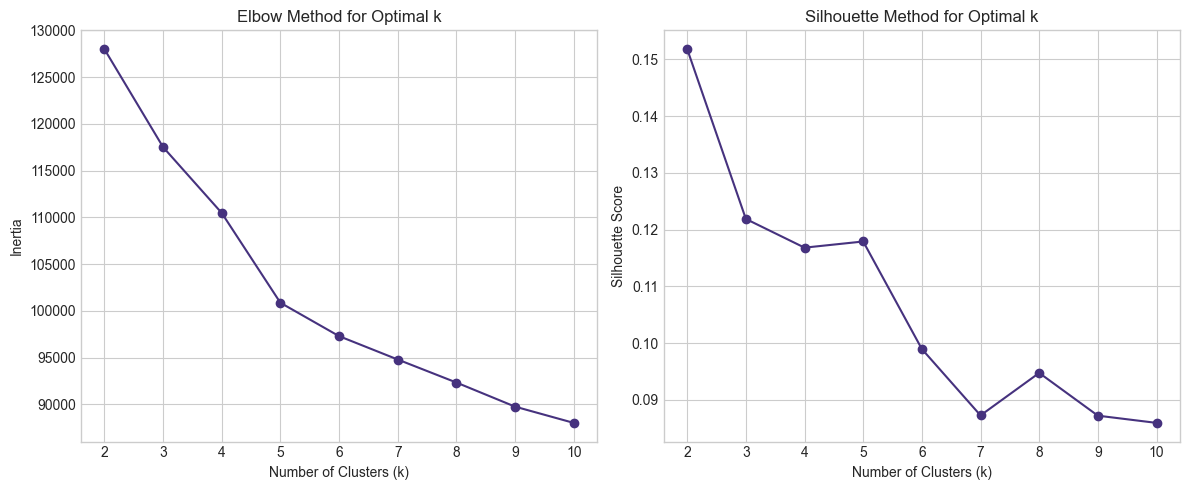

Optimal Clusters Count: 3
Silhouette Score: 0.1219

Cluster distribution:
Cluster 0: 3330 samples (34.91%)
Cluster 1: 3074 samples (32.23%)
Cluster 2: 3134 samples (32.86%)


In [34]:
kmeans, kmeans_labels, kmeans_centroids = perform_kmeans(X_scaled)

In [35]:
from sklearn_extra.cluster import KMedoids
# 3. K-Medoids Clustering
def perform_kmedoids(X_scaled, n_clusters=3):
    # Find optimal number of clusters using silhouette score
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        try:
            kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam', init='k-medoids++')
            kmedoids.fit(X_scaled)

            # Calculate silhouette score
            score = silhouette_score(X_scaled, kmedoids.labels_)
            silhouette_scores.append(score)
            print(f"K={k}, Silhouette Score: {score:.4f}")
        except Exception as e:
            print(f"Error with k={k}: {e}")
            silhouette_scores.append(0)

    # Plot silhouette method
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k (K-Medoids)')
    plt.grid(True)
    plt.show()

    # Determine optimal k based on silhouette score
    if any(silhouette_scores):
        optimal_k = k_range[np.argmax(silhouette_scores)]
    else:
        optimal_k = n_clusters

    print(f"Selected number of clusters: {optimal_k}")
    kmedoids = KMedoids(n_clusters=optimal_k, random_state=42, method='pam', init='k-medoids++')
    kmedoids.fit(X_scaled)

    # Get cluster labels and medoids
    labels = kmedoids.labels_
    medoids = X_scaled[kmedoids.medoid_indices_]

    # Calculate silhouette score for the optimal k
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Count samples in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nCluster distribution:")
    for cluster, count in zip(unique_labels, counts):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

    return kmedoids, labels, medoids

K=2, Silhouette Score: 0.1466
K=3, Silhouette Score: 0.1002
K=4, Silhouette Score: 0.1089
K=5, Silhouette Score: 0.0926
K=6, Silhouette Score: 0.0843
K=7, Silhouette Score: 0.0782
K=8, Silhouette Score: 0.0709
K=9, Silhouette Score: 0.0639
K=10, Silhouette Score: 0.0698


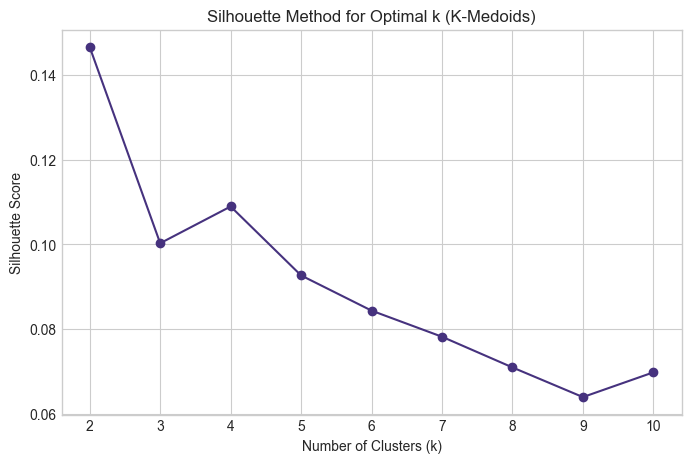

Selected number of clusters: 2
Silhouette Score: 0.1466

Cluster distribution:
Cluster 0: 4032 samples (42.27%)
Cluster 1: 5506 samples (57.73%)


In [36]:
# 3. K-Medoids Clustering
kmedoids, kmedoids_labels, kmedoids_medoids = perform_kmedoids(X_scaled)

In [37]:
# 4. DBSCAN Clustering
def perform_dbscan(X_scaled):
    from sklearn.neighbors import NearestNeighbors

    # Compute the k-distance graph
    n_neighbors = min(15, len(X_scaled)-1)  # Use at most 15 neighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X_scaled)
    distances, indices = neigh.kneighbors(X_scaled)

    # Sort the distances in ascending order and plot
    distances = np.sort(distances[:, n_neighbors-1])

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel('Points (Sorted)')
    plt.ylabel(f'Distance to {n_neighbors}th Nearest Neighbor')
    plt.title('K-Distance Graph for Epsilon Selection')
    plt.grid(True)
    plt.show()

    # Find the "elbow"
    eps_candidates = [0.3, 0.5, 0.7, 1.0, 1.2, 1.5]

    # Try different epsilon values
    results = []
    for eps in eps_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        dbscan.fit(X_scaled)
        labels = dbscan.labels_

        # Number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calculate silhouette score if more than one cluster exists and no single-point clusters
        silhouette_avg = -1  # Default for invalid configurations
        if n_clusters > 1 and n_noise < len(X_scaled):
            # Filter out noise points for silhouette calculation
            valid_indices = labels != -1
            if sum(valid_indices) > 1:  # Need at least 2 points
                try:
                    silhouette_avg = silhouette_score(X_scaled[valid_indices], labels[valid_indices])
                except:
                    silhouette_avg = -1

        results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': n_noise / len(X_scaled) * 100,
            'silhouette': silhouette_avg
        })

        if silhouette_avg >= 0:
            silhouette_str = f"{silhouette_avg:.4f}"
        else:
            silhouette_str = "N/A"

        print(f"Epsilon={eps}: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(X_scaled)*100:.2f}%), Silhouette={silhouette_str}")

    # Select optimal epsilon based on number of clusters and noise percentage
    valid_results = [r for r in results if r['n_clusters'] > 1 and r['noise_percentage'] < 50 and r['silhouette'] > 0]

    if valid_results:
        # Choose the one with the highest silhouette score
        optimal_result = max(valid_results, key=lambda x: x['silhouette'])
        optimal_eps = optimal_result['eps']
    else:
        # Default if no good configuration found
        optimal_eps = 0.5

    min_samples = 5  # This can be adjusted based on dataset size
    print(f"\nSelected parameters: eps={optimal_eps}, min_samples={min_samples}")
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    dbscan.fit(X_scaled)

    # Get cluster labels
    labels = dbscan.labels_

    # Number of clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")

    # Count samples in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nCluster distribution:")
    for cluster, count in zip(unique_labels, counts):
        cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
        print(f"{cluster_name}: {count} samples ({count/len(labels)*100:.2f}%)")

    # Calculate silhouette score if more than one cluster and not all points are noise
    if n_clusters > 1 and n_noise < len(X_scaled):
        # Filter out noise points for silhouette calculation
        valid_indices = labels != -1
        if sum(valid_indices) > 1:  # Need at least 2 points
            try:
                silhouette_avg = silhouette_score(X_scaled[valid_indices], labels[valid_indices])
                print(f"Silhouette Score (excluding noise): {silhouette_avg:.4f}")
            except:
                print("Could not calculate silhouette score.")

    return dbscan, labels

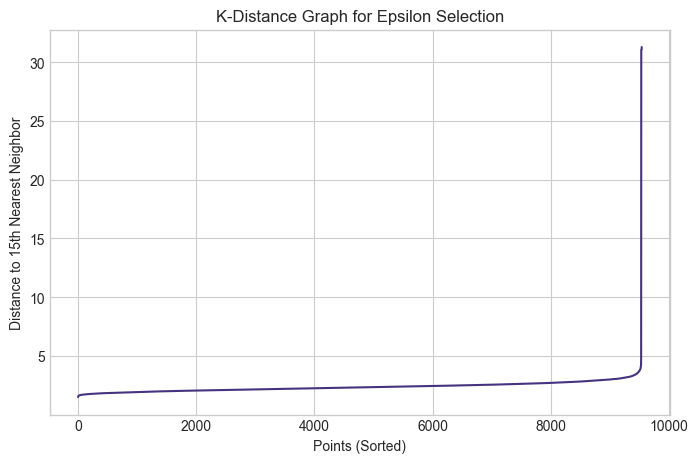

Epsilon=0.3: 0 clusters, 9538 noise points (100.00%), Silhouette=N/A
Epsilon=0.5: 0 clusters, 9538 noise points (100.00%), Silhouette=N/A
Epsilon=0.7: 0 clusters, 9538 noise points (100.00%), Silhouette=N/A
Epsilon=1.0: 0 clusters, 9538 noise points (100.00%), Silhouette=N/A
Epsilon=1.2: 2 clusters, 9528 noise points (99.90%), Silhouette=0.5743
Epsilon=1.5: 69 clusters, 8708 noise points (91.30%), Silhouette=0.0009

Selected parameters: eps=0.5, min_samples=5
Number of clusters: 0
Number of noise points: 9538 (100.00%)

Cluster distribution:
Noise: 9538 samples (100.00%)


In [38]:
# 4. DBSCAN Clustering
dbscan, dbscan_labels = perform_dbscan(X_scaled)

In [39]:
def cluster_analysis(X_scaled, labels, feature_names, algorithm_name):
    print(f"\n{algorithm_name} Cluster Characteristics:")

    # Create DataFrame with original features and cluster labels
    df_analysis = pd.DataFrame(X_scaled, columns=feature_names)
    df_analysis['Cluster'] = labels

    # Calculate mean value for each feature in each cluster
    cluster_means = df_analysis.groupby('Cluster').mean()

    # Create heatmap of cluster characteristics
    plt.figure(figsize=(14, len(cluster_means) * 1.5))
    sns.heatmap(cluster_means, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Z-Score'})
    plt.title(f'{algorithm_name} - Cluster Characteristics (Z-Score Mean Values)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print out key characteristics of each cluster
    for cluster in sorted(df_analysis['Cluster'].unique()):
        if cluster == -1:
            cluster_name = "Noise Points"
        else:
            cluster_name = f"Cluster {cluster}"

        print(f"\n{cluster_name}:")

        # Get the mean values for this cluster
        cluster_data = cluster_means.loc[cluster]

        # Find top features where this cluster differs most from overall mean
        top_features = cluster_data.abs().sort_values(ascending=False).head(5).index

        for feature in top_features:
            value = cluster_data[feature]
            direction = "higher" if value > 0 else "lower"
            print(f"- {feature}: {abs(value):.2f} standard deviations {direction} than average")


In [40]:
from sklearn.decomposition import PCA
# 5. Visualization and Interpretation
def visualize_clusters(X_scaled, kmeans_labels, kmedoids_labels, dbscan_labels, df, feature_names, kmeans_centroids, kmedoids_medoids):

    # Reduce dimensions to 2D for visualization using PCA
    print("Reducing dimensions with PCA for visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Create a figure with subplots
    plt.figure(figsize=(18, 6))

    # 1. K-Means
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)

    # Plot centroids in PCA space
    centroids_pca = pca.transform(kmeans_centroids)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                c='red', marker='X', s=200, label='Centroids', edgecolors='k')

    plt.title('K-Means Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)

    # 2. K-Medoids
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='plasma', alpha=0.7, s=50)

    # Plot medoids in PCA space if we have them
    try:
        medoids_pca = pca.transform(kmedoids_medoids)
        plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1],
                    c='red', marker='X', s=200, label='Medoids', edgecolors='k')
    except:
        print("Could not plot medoids in PCA space.")

    plt.title('K-Medoids Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)

    # 3. DBSCAN
    plt.subplot(1, 3, 3)

    # Get unique labels and create a color map, with -1 (noise) as black
    unique_labels = set(dbscan_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = [0, 0, 0, 1]

        class_member_mask = (dbscan_labels == k)
        xy = X_pca[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f'Cluster {k}' if k != -1 else 'Noise',
                   s=50, alpha=0.7)

    plt.title('DBSCAN Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional visualization: Feature importance per cluster
    print("\nAnalyzing cluster characteristics...")

    # Using K-Means labels for feature analysis (can be repeated for other algorithms)
    cluster_analysis(X_scaled, kmeans_labels, feature_names, algorithm_name="K-Means")
    cluster_analysis(X_scaled, kmedoids_labels, feature_names, algorithm_name="K-Medoids")

    # For DBSCAN, only analyze non-noise points
    valid_indices = dbscan_labels != -1
    if sum(valid_indices) > 0:
        print("\nDBSCAN Cluster Analysis (excluding noise):")
        cluster_analysis(X_scaled[valid_indices], dbscan_labels[valid_indices], feature_names, algorithm_name="DBSCAN")

Reducing dimensions with PCA for visualization...
Explained variance ratio: [0.24619999 0.12581605]


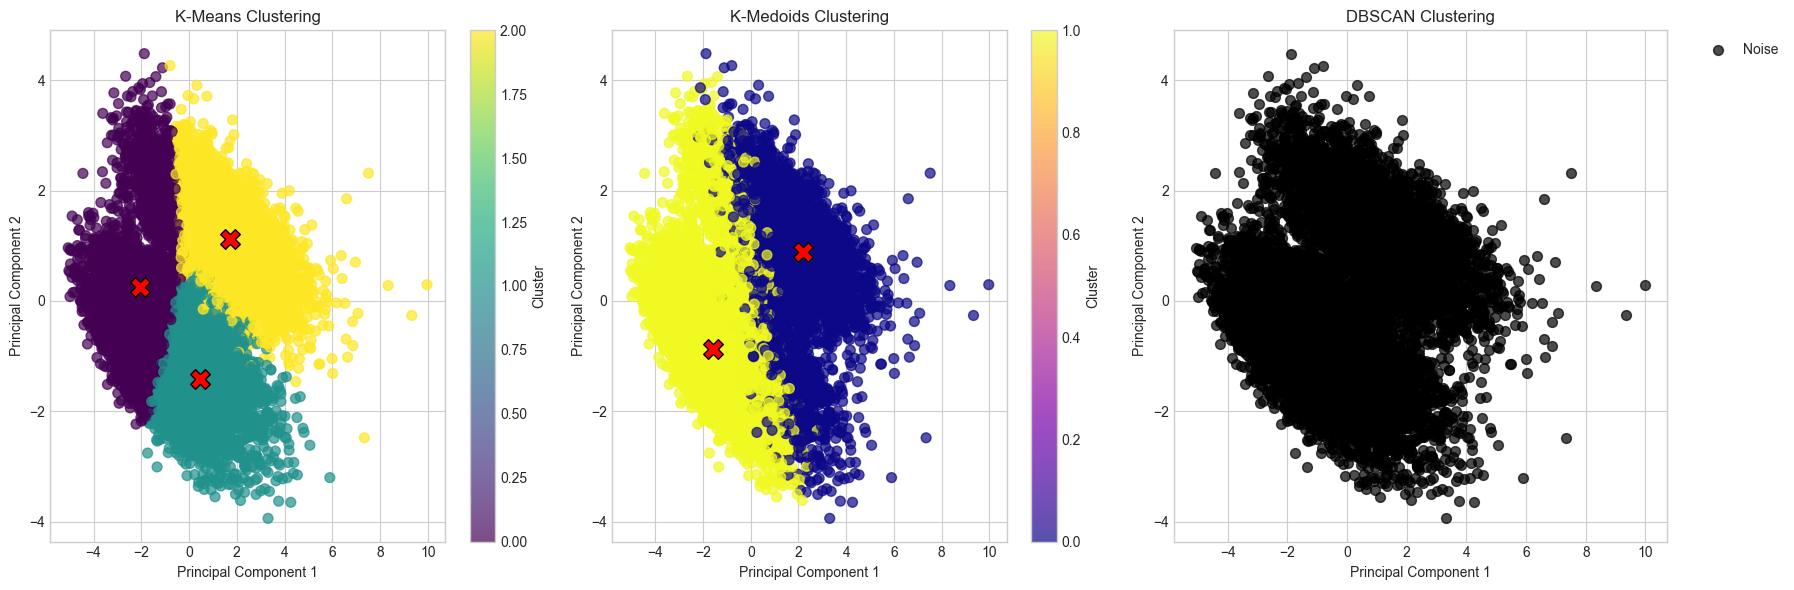


Analyzing cluster characteristics...

K-Means Cluster Characteristics:


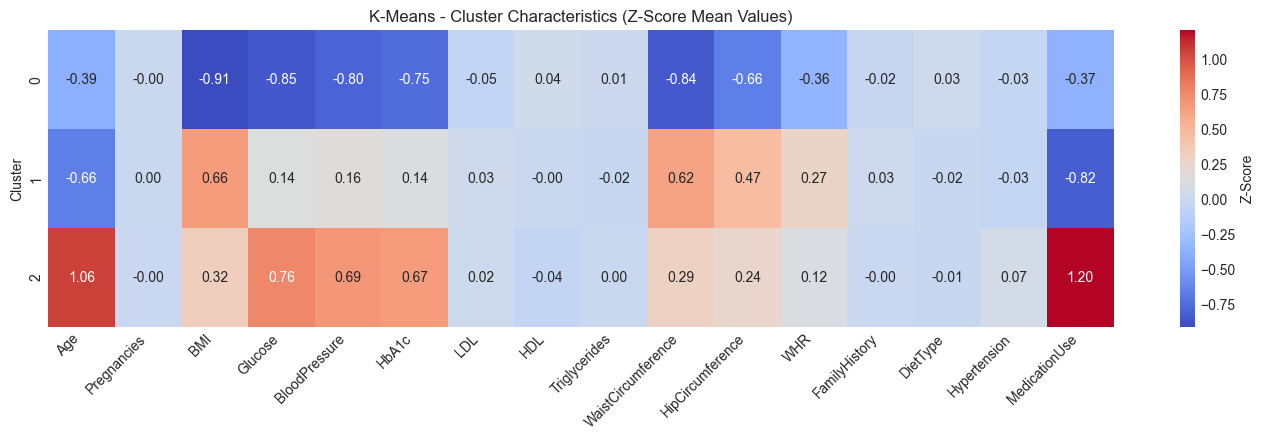


Cluster 0:
- BMI: 0.91 standard deviations lower than average
- Glucose: 0.85 standard deviations lower than average
- WaistCircumference: 0.84 standard deviations lower than average
- BloodPressure: 0.80 standard deviations lower than average
- HbA1c: 0.75 standard deviations lower than average

Cluster 1:
- MedicationUse: 0.82 standard deviations lower than average
- BMI: 0.66 standard deviations higher than average
- Age: 0.66 standard deviations lower than average
- WaistCircumference: 0.62 standard deviations higher than average
- HipCircumference: 0.47 standard deviations higher than average

Cluster 2:
- MedicationUse: 1.20 standard deviations higher than average
- Age: 1.06 standard deviations higher than average
- Glucose: 0.76 standard deviations higher than average
- BloodPressure: 0.69 standard deviations higher than average
- HbA1c: 0.67 standard deviations higher than average

K-Medoids Cluster Characteristics:


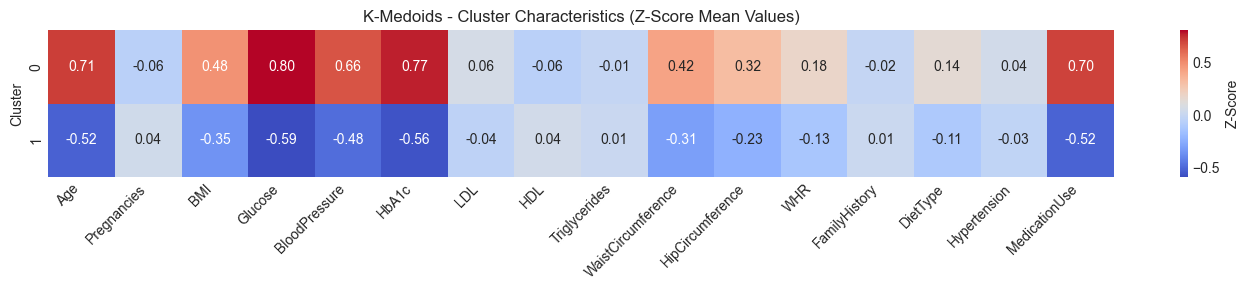


Cluster 0:
- Glucose: 0.80 standard deviations higher than average
- HbA1c: 0.77 standard deviations higher than average
- Age: 0.71 standard deviations higher than average
- MedicationUse: 0.70 standard deviations higher than average
- BloodPressure: 0.66 standard deviations higher than average

Cluster 1:
- Glucose: 0.59 standard deviations lower than average
- HbA1c: 0.56 standard deviations lower than average
- Age: 0.52 standard deviations lower than average
- MedicationUse: 0.52 standard deviations lower than average
- BloodPressure: 0.48 standard deviations lower than average


In [41]:
visualize_clusters(X_scaled, kmeans_labels, kmedoids_labels, dbscan_labels, df, X.columns, kmeans_centroids, kmedoids_medoids)

In [42]:
# 6. Integrated Analysis and Interpretation
def interpret_results(X_scaled, kmeans_labels, kmedoids_labels, dbscan_labels, feature_names):
    """
    Interpret and compare clustering results
    """
    print("\nStep 6: Integrated Analysis and Interpretation")
    print("-------------------------------------------")

    # Calculate Adjusted Rand Index to compare clustering results
    from sklearn.metrics.cluster import adjusted_rand_score

    # Only compare non-noise points for DBSCAN
    valid_indices = dbscan_labels != -1

    if sum(valid_indices) > 0:
        ari_km_kmed = adjusted_rand_score(kmeans_labels, kmedoids_labels)
        ari_km_db = adjusted_rand_score(kmeans_labels[valid_indices], dbscan_labels[valid_indices])
        ari_kmed_db = adjusted_rand_score(kmedoids_labels[valid_indices], dbscan_labels[valid_indices])

        print("\nCluster Similarity (Adjusted Rand Index):")
        print(f"K-Means vs K-Medoids: {ari_km_kmed:.4f}")
        print(f"K-Means vs DBSCAN: {ari_km_db:.4f}")
        print(f"K-Medoids vs DBSCAN: {ari_kmed_db:.4f}")

    print("\nComparative Analysis:")

    # Count clusters
    kmeans_clusters = len(set(kmeans_labels))
    kmedoids_clusters = len(set(kmedoids_labels))
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_noise = list(dbscan_labels).count(-1)

    print(f"K-Means identified {kmeans_clusters} clusters")
    print(f"K-Medoids identified {kmedoids_clusters} clusters")
    print(f"DBSCAN identified {dbscan_clusters} clusters and {dbscan_noise} noise points ({dbscan_noise/len(dbscan_labels)*100:.2f}%)")

    # Calculate silhouette scores for each algorithm
    from sklearn.metrics import silhouette_score

    kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
    kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)

    print("\nCluster Quality (Silhouette Score):")
    print(f"K-Means: {kmeans_silhouette:.4f}")
    print(f"K-Medoids: {kmedoids_silhouette:.4f}")

    if sum(valid_indices) > 1:
        try:
            dbscan_silhouette = silhouette_score(X_scaled[valid_indices], dbscan_labels[valid_indices])
            print(f"DBSCAN (excluding noise): {dbscan_silhouette:.4f}")
        except:
            print("DBSCAN: Could not calculate silhouette score (insufficient points or clusters)")

    print("\nKey Insights and Recommendations:")

    # Determine which algorithm performed best based on silhouette score
    best_algorithm = "K-Means"
    best_score = kmeans_silhouette

    if kmedoids_silhouette > best_score:
        best_algorithm = "K-Medoids"
        best_score = kmedoids_silhouette

    if sum(valid_indices) > 1:
        try:
            if dbscan_silhouette > best_score:
                best_algorithm = "DBSCAN"
                best_score = dbscan_silhouette
        except:
            pass

    print(f"1. Based on silhouette scores, {best_algorithm} provides the most cohesive clusters for this dataset.")

In [43]:
interpret_results(X_scaled, kmeans_labels, kmedoids_labels, dbscan_labels, X.columns)


Step 6: Integrated Analysis and Interpretation
-------------------------------------------

Comparative Analysis:
K-Means identified 3 clusters
K-Medoids identified 2 clusters
DBSCAN identified 0 clusters and 9538 noise points (100.00%)

Cluster Quality (Silhouette Score):
K-Means: 0.1219
K-Medoids: 0.1466

Key Insights and Recommendations:
1. Based on silhouette scores, K-Medoids provides the most cohesive clusters for this dataset.


## 1. Methodology

### Clustering Techniques Employed

- **K-Means Clustering**
  - **Method:** This algorithm partitions the dataset into a pre-specified number of clusters by minimizing the within-cluster sum of squared distances (inertia).
  - **Evaluation:** The **Elbow Method** graph (extracted from the images) shows inertia decreasing with increasing k. The plot indicates that after a certain point (around k = 5–7), the reduction in inertia levels off. Additionally, the **Silhouette Method** was used to quantify the quality of the clusters, where silhouette scores were plotted against different k values.
  - **Result:** K-Means produced 3 clusters with a silhouette score of **0.1219** and a balanced cluster distribution:
    - Cluster 0: 3,330 samples (34.91%)
    - Cluster 1: 3,074 samples (32.23%)
    - Cluster 2: 3,134 samples (32.86%)

- **K-Medoids Clustering**
  - **Method:** Similar to K-Means, but uses actual data points (medoids) to represent clusters, making it more robust to outliers.
  - **Evaluation:** The silhouette scores were calculated for various k values, and among the tested options, a configuration with **k = 2** yielded the highest silhouette score of **0.1466**.
  - **Result:** The clustering resulted in two groups:
    - Cluster 0: 4,032 samples (42.27%)
    - Cluster 1: 5,506 samples (57.73%)
  - The higher silhouette score indicates that K-Medoids provided slightly more cohesive clusters for this dataset.

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
  - **Method:** DBSCAN clusters based on the density of data points, identifying noise (outliers) without predefining the number of clusters.
  - **Evaluation:** Various epsilon (eps) values were tested with a fixed minimum samples parameter (min_samples=5). For eps values of 0.3, 0.5, 0.7, and 1.0, no clusters were identified (100% of samples were marked as noise). Only when using eps=1.2 did the algorithm form 2 clusters, but with 99.90% of the data remaining as noise. At eps=1.5, an overly fragmented result (69 clusters with 91.30% noise) was observed.
  - **Result:** The selected parameters (eps=0.5, min_samples=5) yielded no clusters, suggesting that DBSCAN was not effective for this dataset under standard settings.

---

## 2. Performance Metrics

- **Silhouette Scores:**
  - *K-Means:* 0.1219
  - *K-Medoids:* 0.1466
  - *DBSCAN:* Not applicable with the selected parameters (or yielded low-quality clusters at alternative settings).

- **Cluster Distributions:**
  - *K-Means (3 clusters):* Fairly even distribution among clusters.
  - *K-Medoids (2 clusters):* Slightly imbalanced, but with a higher silhouette score indicating more distinct separation.

- **Graphical Insights:**
  - The **Elbow Method** graph (from the images) shows a decreasing inertia trend with increasing k, where the “elbow” suggests an optimal range between 5 and 7 clusters.
  - The **Silhouette Method** graph indicates that while there is a trade-off in selecting k, a silhouette peak around a lower k (such as 2 or 3) was observed, which aligns with the K-Medoids result.

---

## 3. Insights Gained from Analyzing Patient Clusters

### Common Trends Across Clustering Methods

- **K-Means vs. K-Medoids:**
  - **K-Means** with 3 clusters identifies more granular groupings. However, the silhouette score suggests that these groups have moderate cohesion.
  - **K-Medoids** with 2 clusters, while fewer in number, deliver a slightly better-defined separation between patient groups.

### Patient Characteristics and Cluster Profiles

- **General Population Trends (PCA Results):**
  - The first two principal components (explaining variances of approximately 24.6% and 12.6%) indicate that key features such as Age, WaistCircumference, and HipCircumference drive variation in the dataset. For instance, the overall patient population shows:
  - Age is 0.66 standard deviations lower than average
  - WaistCircumference is 0.62 standard deviations higher than average
  - HipCircumference is 0.47 standard deviations higher than average

- **Distinct Risk Profiles:**
  - **High-Risk Group (e.g., Cluster 2 in K-Means):** Patients who exhibit higher values in MedicationUse, Age, Glucose, BloodPressure, and HbA1c (with increases ranging from 0.67 to 1.20 standard deviations above average) are indicative of a group with elevated risk profiles. This cluster could represent patients who require more intensive management for chronic conditions.

- **Outliers and Noise:**
  - DBSCAN's inability to form clusters under typical settings suggests that the dataset is densely packed without clear density-based separations, or the chosen parameters do not capture the underlying structure. This emphasizes the need to rely on centroid-based clustering (K-Means or K-Medoids) for this dataset.

---

## 4. Recommendations for Healthcare Providers

### Personalized Treatment Strategies

- **High-Risk Patients:**
  - For groups identified with higher age, glucose levels, blood pressure, and other risk indicators (as seen in one of the K-Means clusters), targeted interventions such as chronic disease management, regular monitoring, and personalized medication regimes should be prioritized.

- **Preventive Care for Moderate Risk:**
  - Patients in clusters showing moderate deviations from average values may benefit from preventive care programs that emphasize lifestyle changes, regular screening, and early intervention strategies.

- **Resource Allocation:**
  - Clustering results can guide resource allocation—ensuring that high-risk patients receive focused specialist care while moderate- and low-risk patients are managed with routine wellness programs.
  - The differences between K-Means and K-Medoids insights suggest that while more granular clusters (K-Means) provide detailed subgrouping, the more cohesive clusters (K-Medoids) might be preferable for designing broadly targeted treatment protocols.

### Operational Implications

- **Risk Stratification:**
  - Use cluster profiles to stratify patients into risk categories, enabling hospitals and clinics to tailor outreach and education programs according to the specific needs of each group.

- **Data-Driven Decision Making:**
  - Integrate cluster analysis with other clinical indicators to form a robust decision-support system for patient management.

- **Continuous Monitoring:**
  - As patient data evolves, periodic re-clustering can ensure that the treatment protocols remain aligned with the current population health trends.

---

## 5. Integrated Interpretation of Results

- **Comparison of Clustering Techniques:**
  - **K-Means** provides more segmented groups (3 clusters) that can capture subtle differences in patient profiles, though with a lower silhouette score (0.1219) indicating moderate cohesion.
  - **K-Medoids** results in 2 clusters with a higher silhouette score (0.1466), suggesting better-defined groupings that may be more reliable for broad treatment categorization.
  - **DBSCAN** was less effective under the selected parameters, as it either identified all points as noise or produced impractical cluster fragmentation.

- **Distinct Groups and Insights:**
  - A notable high-risk cluster is observed where patients have higher MedicationUse, Age, Glucose, BloodPressure, and HbA1c levels. This suggests that these patients are more likely to suffer from chronic conditions and would benefit from intensive interventions.
  - The PCA-based analysis confirms that physical metrics (waist and hip circumference) and age are significant differentiators, reinforcing the need to focus on lifestyle-related interventions.

- **Implications for Healthcare:**
  - The analysis suggests that even with modest silhouette scores, the clustering techniques reveal valuable insights into patient heterogeneity. Tailoring treatments based on these clusters can improve outcomes through targeted care, efficient resource utilization, and proactive management of at-risk populations.